In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

### DATA UPLOAD

In [19]:
ARRESTS_2023 = "arrests_2023.csv"
BOROPOP_CSV = "NYC_Borough_Population.csv"

OUTDIR = Path("outputs_bias_starter")
OUTDIR.mkdir(parents=True, exist_ok=True)

In [21]:
import requests, io
import pandas as pd

BASE = "https://data.cityofnewyork.us/resource/qgea-i56i.csv"  # NYPD Complaint Data (Historic)

params = {
    "$select": "date_trunc_ym(cmplnt_fr_dt) as ym, boro_nm, addr_pct_cd, "
               "law_cat_cd, ofns_desc, count(1) as complaints",
    "$where": "cmplnt_fr_dt between '2023-01-01T00:00:00' and '2023-12-31T23:59:59'",
    "$group": "ym, boro_nm, addr_pct_cd, law_cat_cd, ofns_desc",
    "$order": "ym, boro_nm, addr_pct_cd",
    "$limit": 60000  # well under API cap
}

r = requests.get(BASE, params=params)
r.raise_for_status()  # will show you the exact API error if something goes wrong

COMPLAINTS_2023  = pd.read_csv(io.StringIO(r.text), parse_dates=["ym"])


In [22]:
BORO_MAP = {
    "B": "Bronx",
    "K": "Brooklyn",
    "M": "Manhattan",
    "Q": "Queens",
    "S": "Staten Island",
}

def to_month(dt_series):
    s = pd.to_datetime(dt_series, errors="coerce")
    return s.dt.to_period("M").dt.to_timestamp()

def clean_str(s):
    return s.str.strip().str.upper()

def read_borough_pop(path):
    """
    Tries to read a messy borough population CSV.
    Needs columns containing borough name and population.
    Accepts a few common header variants; final returns:
    DataFrame with columns: boro_name, population
    """
    df = pd.read_csv(path, on_bad_lines="skip")
    # Normalize headers
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

    # Heuristic pickers
    boro_col = None
    pop_col  = None
    for c in df.columns:
        if any(k in c for k in ["borough", "boro", "county", "name"]):
            boro_col = c if boro_col is None else boro_col
        if any(k in c for k in ["population", "pop", "total"]):
            pop_col = c if pop_col is None else pop_col

    if boro_col is None or pop_col is None:
        raise ValueError(
            f"Could not infer borough/population columns from: {df.columns.tolist()}"
        )

    out = df[[boro_col, pop_col]].copy()
    out.columns = ["boro_name", "population"]
    out["boro_name"] = out["boro_name"].astype(str).str.strip().str.title()
    out["population"] = pd.to_numeric(out["population"].astype(str).str.replace(",", ""), errors="coerce")
    out = out.dropna(subset=["population"]).groupby("boro_name", as_index=False)["population"].sum()

    # Keep only NYC 5 boroughs
    keep = {"Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"}
    out = out[out["boro_name"].isin(keep)].reset_index(drop=True)
    return out

### Data Normalization

In [25]:
arrests = pd.read_csv(ARRESTS_2023, low_memory=False)

# Normalize column names
arrests.columns = [c.strip().upper() for c in arrests.columns]
rename_ar = {
    "ARREST_DATE": "DATE",
    "OFNS_DESC": "OFFENSE",
    "LAW_CAT_CD": "SEVERITY",
    "ARREST_BORO": "BORO",
    "ARREST_PRECINCT": "PRECINCT",
    "PERP_RACE": "RACE",
    "PERP_SEX": "SEX",
    "PERP_AGE_GROUP": "AGE_GROUP",
}
for k, v in rename_ar.items():
    if k in arrests.columns:
        arrests.rename(columns={k: v}, inplace=True)

# Minimal fields used here
need_ar = ["DATE","OFFENSE","SEVERITY","BORO","PRECINCT","RACE","SEX","AGE_GROUP"]
arrests = arrests[[c for c in need_ar if c in arrests.columns]].copy()

# Coerce types
arrests["DATE"] = pd.to_datetime(arrests["DATE"], errors="coerce")
if "BORO" in arrests.columns:
    arrests["BORO"] = arrests["BORO"].astype(str).str.strip().str.upper().map(BORO_MAP).fillna(arrests["BORO"])
if "PRECINCT" in arrests.columns:
    arrests["PRECINCT"] = pd.to_numeric(arrests["PRECINCT"], errors="coerce").astype("Int64")
if "SEVERITY" in arrests.columns:
    arrests["SEVERITY"] = arrests["SEVERITY"].astype(str).str.upper().str.strip()
if "OFFENSE" in arrests.columns:
    arrests["OFFENSE"] = arrests["OFFENSE"].astype(str).str.upper().str.strip()

arrests["YM"] = to_month(arrests["DATE"])


In [29]:
import requests, io
import pandas as pd

def load_complaints_2023_summary():
    BASE = "https://data.cityofnewyork.us/resource/qgea-i56i.csv"  # NYPD Complaint Data - Historic
    params = {
        "$select": "date_trunc_ym(cmplnt_fr_dt) as ym, boro_nm, addr_pct_cd, law_cat_cd, ofns_desc, count(1) as complaints",
        "$where": "cmplnt_fr_dt between '2023-01-01T00:00:00' and '2023-12-31T23:59:59'",
        "$group": "ym, boro_nm, addr_pct_cd, law_cat_cd, ofns_desc",
        "$order": "ym, boro_nm, addr_pct_cd",
        "$limit": 60000
    }
    r = requests.get(BASE, params=params)   # requests handles encoding
    r.raise_for_status()
    df = pd.read_csv(io.StringIO(r.text), parse_dates=["ym"])
    # standardize columns
    df = df.rename(columns={
        "ym":"YM", "boro_nm":"BORO", "addr_pct_cd":"PRECINCT",
        "ofns_desc":"OFFENSE", "law_cat_cd":"SEVERITY"
    })
    df["PRECINCT"] = pd.to_numeric(df["PRECINCT"], errors="coerce").astype("Int64")
    df["BORO"] = df["BORO"].astype(str).str.title()
    return df

compl = load_complaints_2023_summary()
print(compl.shape, compl.head())


(31424, 6)           YM   BORO  PRECINCT SEVERITY                         OFFENSE  \
0 2023-01-01  Bronx        40   FELONY                           ARSON   
1 2023-01-01  Bronx        40   FELONY                        BURGLARY   
2 2023-01-01  Bronx        40   FELONY       CANNABIS RELATED OFFENSES   
3 2023-01-01  Bronx        40   FELONY  CRIMINAL MISCHIEF & RELATED OF   
4 2023-01-01  Bronx        40   FELONY                 DANGEROUS DRUGS   

   complaints  
0           2  
1          24  
2           1  
3          43  
4          20  


In [33]:
def normalize_offense(s):
    s = (s or "").upper()
    for key in ["ASSAULT","ROBBERY","LARCENY","NARCOTIC","DANGEROUS DRUG","BURGLARY","FRAUD","WEAPON","SEX","HOMICIDE","TRESPASS"]:
        if key in s:
            return key
    return s[:40]  # truncate long tail
arrests["OFFENSE_FAM"] = arrests["OFFENSE"].apply(normalize_offense) if "OFFENSE" in arrests else np.nan
compl["OFFENSE_FAM"]   = compl["OFFENSE"].apply(normalize_offense) if "OFFENSE" in compl else np.nan

ar_boro_m = arrests.groupby(["YM","BORO"], dropna=False).size().reset_index(name="arrests")
ar_prec_m = arrests.groupby(["YM","PRECINCT"], dropna=False).size().reset_index(name="arrests")

# Complaints
cp_boro_m = compl.groupby(["YM","BORO"], dropna=False).size().reset_index(name="complaints")
cp_prec_m = compl.groupby(["YM","PRECINCT"], dropna=False).size().reset_index(name="complaints")

# Join to get ACR = arrests / complaints
boro_m = pd.merge(ar_boro_m, cp_boro_m, on=["YM","BORO"], how="outer")
boro_m["arrests"] = boro_m["arrests"].fillna(0).astype(int)
boro_m["complaints"] = boro_m["complaints"].fillna(0).astype(int)
boro_m["ACR"] = np.where(boro_m["complaints"]>0, boro_m["arrests"]/boro_m["complaints"], np.nan)

prec_m = pd.merge(ar_prec_m, cp_prec_m, on=["YM","PRECINCT"], how="outer")
prec_m["arrests"] = prec_m["arrests"].fillna(0).astype(int)
prec_m["complaints"] = prec_m["complaints"].fillna(0).astype(int)
prec_m["ACR"] = np.where(prec_m["complaints"]>0, prec_m["arrests"]/prec_m["complaints"], np.nan)

# Save panels
boro_m.to_csv(OUTDIR/"panel_monthly_borough2023.csv", index=False)
prec_m.to_csv(OUTDIR/"panel_monthly_precinct2023.csv", index=False)

print("Saved:", OUTDIR/"panel_monthly_borough2023.csv", OUTDIR/"panel_monthly_precinct2023.csv")

Saved: outputs_bias_starter/panel_monthly_borough2023.csv outputs_bias_starter/panel_monthly_precinct2023.csv


In [35]:
import pandas as pd
import numpy as np

def try_read_boro_pop(path):
    """
    Robust reader for messy borough population CSVs.
    Returns columns: boro_name, population
    Falls back to 2020 Census if parsing fails.
    """
    candidates = []
    # 1) normal fast parse
    try:
        candidates.append(pd.read_csv(path))
    except Exception:
        pass
    # 2) python engine, auto-sep inference
    try:
        candidates.append(pd.read_csv(path, engine="python"))
    except Exception:
        pass
    # 3) tolerant parse, skip bad lines
    try:
        candidates.append(pd.read_csv(path, engine="python", on_bad_lines="skip"))
    except Exception:
        pass

    # Heuristic cleaner for each candidate
    for df in candidates:
        if df is None or df.empty:
            continue
        df = df.copy()
        df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

        # If it's a single messy column, try to split on comma or tab
        if df.shape[1] == 1:
            col = df.columns[0]
            # attempt comma split
            tmp = df[col].astype(str).str.split(",", n=1, expand=True)
            if tmp.shape[1] == 2:
                tmp.columns = ["left","right"]
                df = tmp
        # Try to guess columns
        boro_col = None
        pop_col  = None
        for c in df.columns:
            if any(k in c for k in ["borough", "boro", "county", "name"]):
                boro_col = c if boro_col is None else boro_col
            if any(k in c for k in ["population", "pop", "total"]):
                pop_col = c if pop_col is None else pop_col

        if boro_col is not None and pop_col is not None:
            out = df[[boro_col, pop_col]].dropna().copy()
            out.columns = ["boro_name", "population"]
            out["boro_name"] = out["boro_name"].astype(str).str.strip().str.title()
            out["population"] = (
                out["population"].astype(str).str.replace(",", "").str.extract(r"(\d+)", expand=False)
            ).astype(float)
            out = out.dropna(subset=["population"])
            # Keep only NYC 5 boroughs
            keep = {"Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"}
            out = out[out["boro_name"].isin(keep)].groupby("boro_name", as_index=False)["population"].sum()
            if not out.empty and set(out["boro_name"]) <= keep:
                return out

    fallback = pd.DataFrame({
        "boro_name": ["Bronx","Brooklyn","Manhattan","Queens","Staten Island"],
        "population": [1472654, 2736074, 1694251, 2405464, 495747],
    })
    print("[WARN] Using fallback 2020 Census borough populations (file parse failed).")
    return fallback

# Use the robust reader
boro_pop = try_read_boro_pop(BOROPOP_CSV)

# Align names and compute per-capita
boro_m_pc = boro_m.merge(boro_pop, left_on="BORO", right_on="boro_name", how="left")
missing = boro_m_pc["population"].isna().sum()
if missing:
    print(f"[WARN] {missing} rows missing population (likely name mismatch). Example values:", 
          boro_m_pc.loc[boro_m_pc["population"].isna(), "BORO"].unique())

boro_m_pc["arrests_per_10k"] = (boro_m_pc["arrests"] / boro_m_pc["population"] * 10000).round(3)
boro_m_pc["complaints_per_10k"] = (boro_m_pc["complaints"] / boro_m_pc["population"] * 10000).round(3)

# Save
out_path = OUTDIR / "panel_monthly_borough_percap.csv"
boro_m_pc.to_csv(out_path, index=False)
print("Saved per-cap panel →", out_path)

[WARN] Using fallback 2020 Census borough populations (file parse failed).
[WARN] 12 rows missing population (likely name mismatch). Example values: ['(Null)']
Saved per-cap panel → outputs_bias_starter/panel_monthly_borough_percap.csv


In [ ]:
if set(["RACE", "OFFENSE_FAM", "YM", "BORO"]).issubset(arrests.columns):
    race_off_m = (
        arrests
        .groupby(["YM", "BORO", "OFFENSE_FAM", "RACE"], dropna=False)
        .size()
        .reset_index(name="arrests")
    )

    # Shares within (YM, BORO, OFFENSE_FAM)
    race_off_m["share"] = (
        race_off_m["arrests"] /
        race_off_m.groupby(["YM", "BORO", "OFFENSE_FAM"])["arrests"].transform("sum")
    )
    race_off_m["share_pct"] = (race_off_m["share"] * 100).round(2)

    out_fp = OUTDIR / "arrests_race_by_offense_monthly.csv"
    race_off_m.to_csv(out_fp, index=False)
    print("Saved:", out_fp)
else:
    missing = {"RACE", "OFFENSE_FAM", "YM", "BORO"} - set(arrests.columns)
    print("Missing required columns:", missing)


In [39]:
if set(["RACE", "OFFENSE_FAM", "YM", "BORO"]).issubset(arrests.columns):
    race_off_m = (
        arrests
        .groupby(["YM", "BORO", "OFFENSE_FAM", "RACE"], dropna=False)
        .size()
        .reset_index(name="arrests")
    )

    # Shares within (YM, BORO, OFFENSE_FAM)
    race_off_m["share"] = (
        race_off_m["arrests"] /
        race_off_m.groupby(["YM", "BORO", "OFFENSE_FAM"])["arrests"].transform("sum")
    )
    race_off_m["share_pct"] = (race_off_m["share"] * 100).round(2)

    out_fp = OUTDIR / "arrests_race_by_offense_monthly.csv"
    race_off_m.to_csv(out_fp, index=False)
    print("Saved:", out_fp)
else:
    missing = {"RACE", "OFFENSE_FAM", "YM", "BORO"} - set(arrests.columns)
    print("Missing required columns:", missing)


Saved: outputs_bias_starter/arrests_race_by_offense_monthly.csv


### Temporal

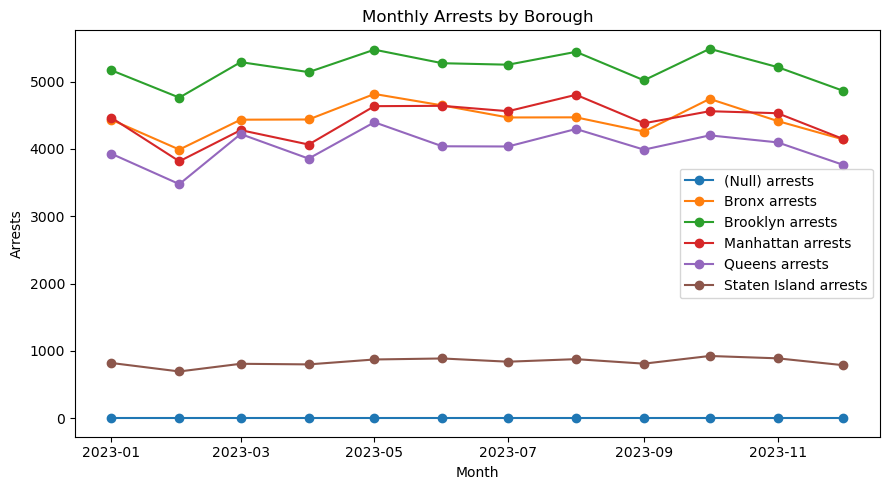

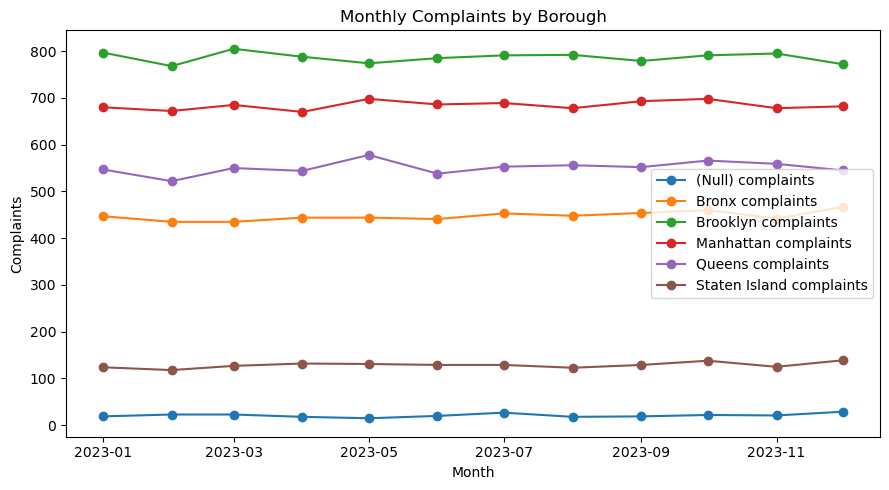

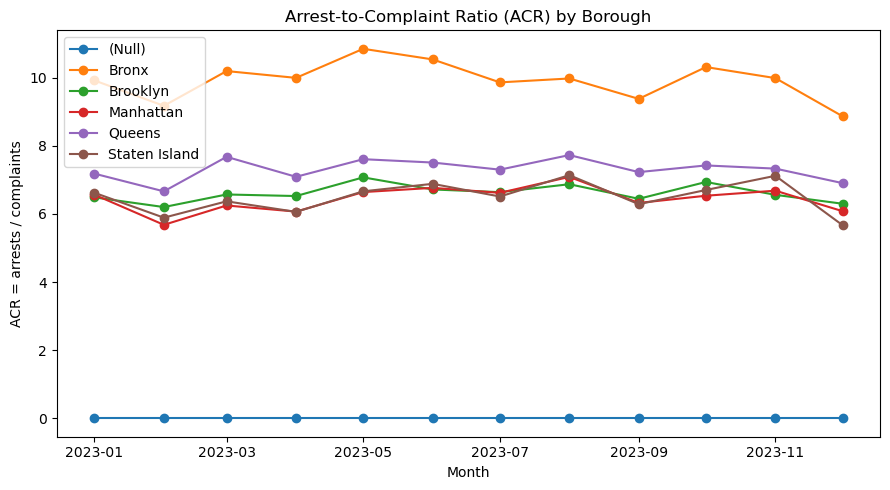

In [131]:


# Monthly arrests by borough
fig, ax = plt.subplots(figsize=(9,5))
for b in sorted(boro_m["BORO"].dropna().unique()):
    tmp = boro_m[boro_m["BORO"] == b].sort_values("YM")
    ax.plot(tmp["YM"], tmp["arrests"], marker="o", label=f"{b} arrests")
ax.set_title("Monthly Arrests by Borough")
ax.set_xlabel("Month")
ax.set_ylabel("Arrests")
ax.legend()
plt.tight_layout()
plt.show()

# Monthly complaints by borough
fig, ax = plt.subplots(figsize=(9,5))
for b in sorted(boro_m["BORO"].dropna().unique()):
    tmp = boro_m[boro_m["BORO"] == b].sort_values("YM")
    ax.plot(tmp["YM"], tmp["complaints"], marker="o", label=f"{b} complaints")
ax.set_title("Monthly Complaints by Borough")
ax.set_xlabel("Month")
ax.set_ylabel("Complaints")
ax.legend()
plt.tight_layout()
plt.show()

# ACR by borough (higher = more arrests per complaint)
fig, ax = plt.subplots(figsize=(9,5))
for b in sorted(boro_m["BORO"].dropna().unique()):
    tmp = boro_m[boro_m["BORO"] == b].sort_values("YM")
    ax.plot(tmp["YM"], tmp["ACR"], marker="o", label=b)
ax.set_title("Arrest-to-Complaint Ratio (ACR) by Borough")
ax.set_xlabel("Month")
ax.set_ylabel("ACR = arrests / complaints")
ax.legend()
plt.tight_layout()
plt.show()


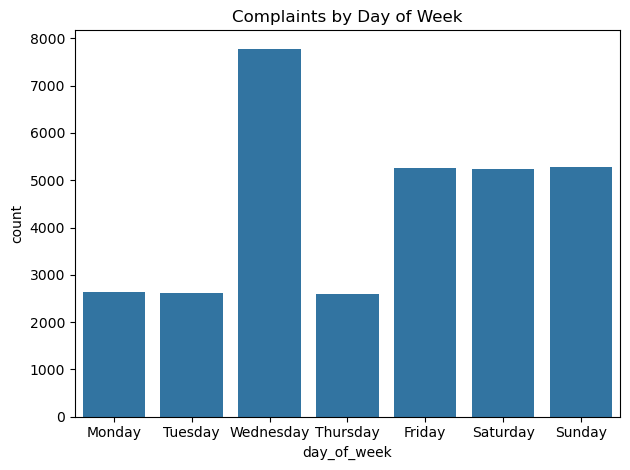

In [134]:
# Day-of-week patterns
compl["day_of_week"] = compl["DATE"].dt.day_name()
sns.countplot(data=compl, x="day_of_week", order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Complaints by Day of Week")
plt.tight_layout(); plt.show()

/var/folders/h4/ghspzbdd5rn19t61r1slxsf40000gn/T/ipykernel_31928/1377554529.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=boro_mean, x="BORO", y="arrests_per_10k", palette="Reds")


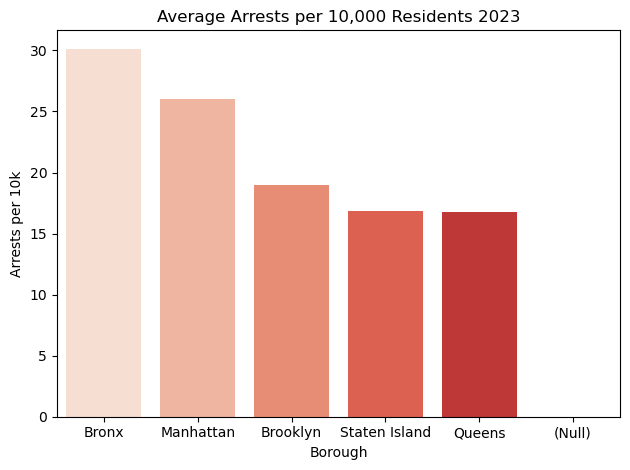

,BORO,arrests_per_10k,complaints_per_10k
1,Bronx,30.137250,3.038750
3,Manhattan,26.014917,4.037750
2,Brooklyn,19.003667,2.874333
5,Staten Island,16.839917,2.595333
4,Queens,16.736250,2.290000
0,(Null),NaN,NaN


In [43]:
 import seaborn as sns

boro_mean = (
    boro_m_pc.groupby("BORO")[["arrests_per_10k","complaints_per_10k"]]
    .mean()
    .reset_index()
    .sort_values("arrests_per_10k", ascending=False)
)
sns.barplot(data=boro_mean, x="BORO", y="arrests_per_10k", palette="Reds")
plt.title("Average Arrests per 10,000 Residents 2023")
plt.ylabel("Arrests per 10k"); plt.xlabel("Borough")
plt.tight_layout(); plt.show()

display(boro_mean)

In [49]:
# ACR outliers (> 2 SD above mean)
city_mu = prec_m["ACR"].mean()
city_sd = prec_m["ACR"].std()
prec_m["ACR_z"] = (prec_m["ACR"] - city_mu) / city_sd
outliers = prec_m[prec_m["ACR_z"] >= 2].sort_values("ACR_z", ascending=False)
print("High-ACR Precincts (potential outliers):")
display(outliers.head(15))

High-ACR Precincts (potential outliers):


,YM,PRECINCT,arrests,complaints,ACR,ACR_z
397,2023-06-01,14,714,37,19.297297,3.883388
728,2023-10-01,44,679,37,18.351351,3.588772
553,2023-08-01,14,751,42,17.880952,3.442266
319,2023-05-01,14,725,41,17.682927,3.380591
416,2023-06-01,44,697,41,17.000000,3.167893
334,2023-05-01,40,658,39,16.871795,3.127963
475,2023-07-01,14,741,44,16.840909,3.118344
412,2023-06-01,40,652,40,16.300000,2.949877
338,2023-05-01,44,678,42,16.142857,2.900935
436,2023-06-01,75,663,42,15.785714,2.789703


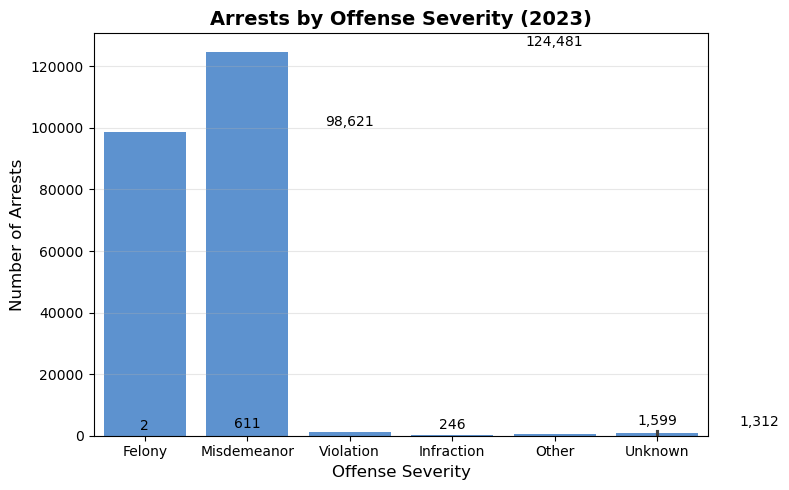

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Group by offense severity and count
arrests_severity = (
    arrests.groupby("SEVERITY")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)


severity_map = {
    "F": "Felony",
    "M": "Misdemeanor",
    "V": "Violation",
    "I": "Infraction",
    "9": "Other",
    "(NULL)": "Unknown",
    "NAN": "Unknown",
    np.nan: "Unknown"
}
arrests_severity["SEVERITY"] = arrests_severity["SEVERITY"].replace(severity_map)

# Define desired order (only if those categories exist)
order = [s for s in ["Felony", "Misdemeanor", "Violation", "Infraction", "Other", "Unknown"]
         if s in arrests_severity["SEVERITY"].unique()]

plt.figure(figsize=(8,5))
sns.barplot(
    data=arrests_severity,
    x="SEVERITY", y="count",
    order=order,
    color="#4A90E2"
)
plt.title("Arrests by Offense Severity (2023)", fontsize=14, weight="bold")
plt.xlabel("Offense Severity", fontsize=12)
plt.ylabel("Number of Arrests", fontsize=12)
plt.grid(axis="y", alpha=0.3)

# Add text labels above bars
for i, row in arrests_severity.iterrows():
    plt.text(
        i, row["count"] + 1000, f"{int(row['count']):,}",
        ha="center", va="bottom", fontsize=10
    )

plt.tight_layout()
plt.show()

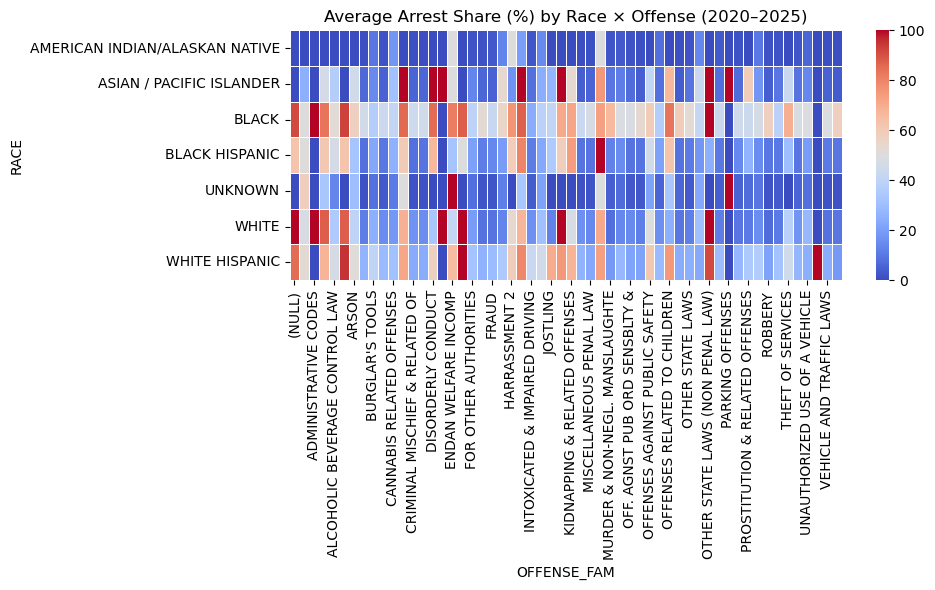

In [59]:
race_off = pd.read_csv(OUTDIR / "arrests_race_by_offense_monthly.csv")
race_off = race_off[(race_off["YM"] >= "2023-01-01") & (race_off["YM"] <= "2023-12-31")]

race_summary = (
    race_off.groupby(["OFFENSE_FAM","RACE"])["share_pct"]
    .mean().reset_index()
)
pivot = race_summary.pivot(index="RACE", columns="OFFENSE_FAM", values="share_pct").fillna(0)

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap="coolwarm", linewidths=.5)
plt.title("Average Arrest Share (%) by Race × Offense (2023)")
plt.tight_layout(); plt.show()

### Racial Composition of ASSULT by Boro

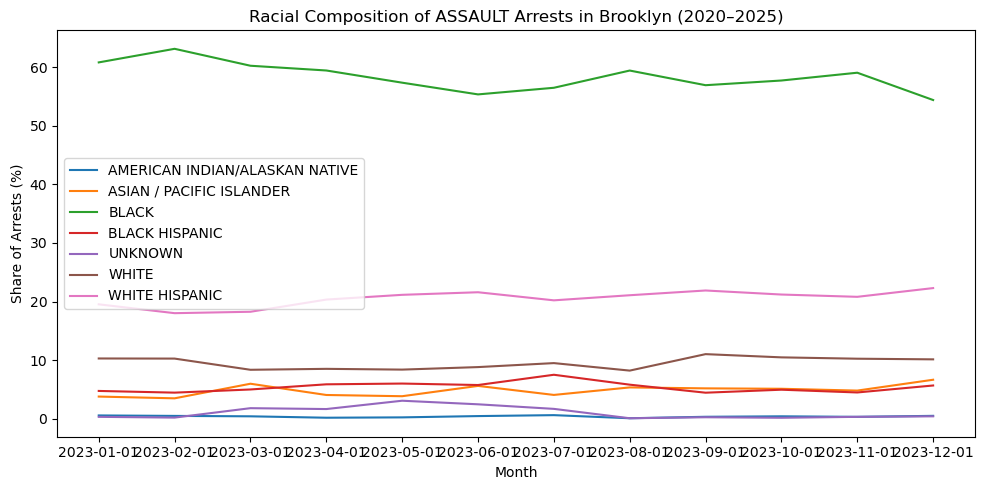

In [61]:
offense = "ASSAULT"
boro = "Brooklyn"
tmp = race_off[(race_off["OFFENSE_FAM"]==offense) & (race_off["BORO"]==boro)].sort_values("YM")

plt.figure(figsize=(10,5))
sns.lineplot(data=tmp, x="YM", y="share_pct", hue="RACE")
plt.title(f"Racial Composition of {offense} Arrests in {boro} (2020–2025)")
plt.xlabel("Month"); plt.ylabel("Share of Arrests (%)")
plt.legend(); plt.tight_layout(); plt.show()


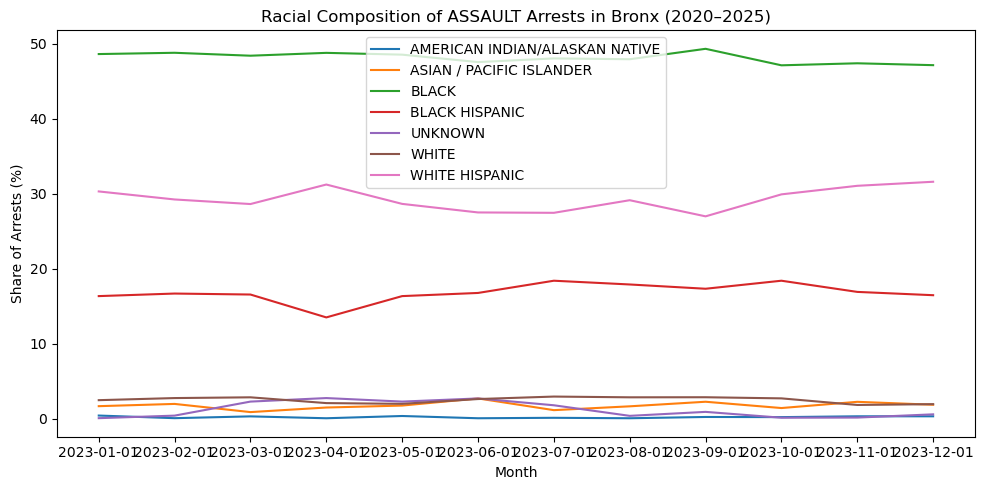

In [63]:
offense = "ASSAULT"
boro = "Bronx"
tmp = race_off[(race_off["OFFENSE_FAM"]==offense) & (race_off["BORO"]==boro)].sort_values("YM")

plt.figure(figsize=(10,5))
sns.lineplot(data=tmp, x="YM", y="share_pct", hue="RACE")
plt.title(f"Racial Composition of {offense} Arrests in {boro} (2020–2025)")
plt.xlabel("Month"); plt.ylabel("Share of Arrests (%)")
plt.legend(); plt.tight_layout(); plt.show()

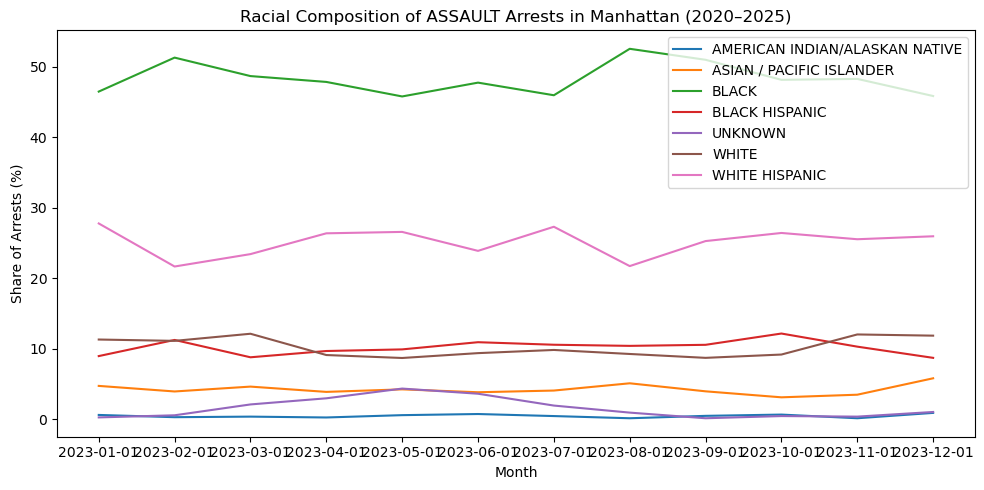

In [65]:
offense = "ASSAULT"
boro = "Manhattan"
tmp = race_off[(race_off["OFFENSE_FAM"]==offense) & (race_off["BORO"]==boro)].sort_values("YM")

plt.figure(figsize=(10,5))
sns.lineplot(data=tmp, x="YM", y="share_pct", hue="RACE")
plt.title(f"Racial Composition of {offense} Arrests in {boro} (2020–2025)")
plt.xlabel("Month"); plt.ylabel("Share of Arrests (%)")
plt.legend(); plt.tight_layout(); plt.show()

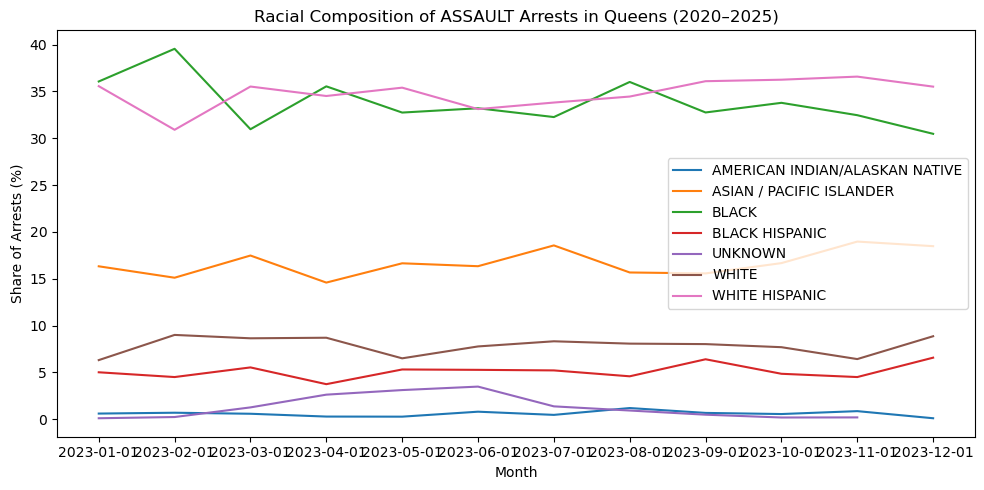

In [67]:
offense = "ASSAULT"
boro = "Queens"
tmp = race_off[(race_off["OFFENSE_FAM"]==offense) & (race_off["BORO"]==boro)].sort_values("YM")

plt.figure(figsize=(10,5))
sns.lineplot(data=tmp, x="YM", y="share_pct", hue="RACE")
plt.title(f"Racial Composition of {offense} Arrests in {boro} (2020–2025)")
plt.xlabel("Month"); plt.ylabel("Share of Arrests (%)")
plt.legend(); plt.tight_layout(); plt.show()

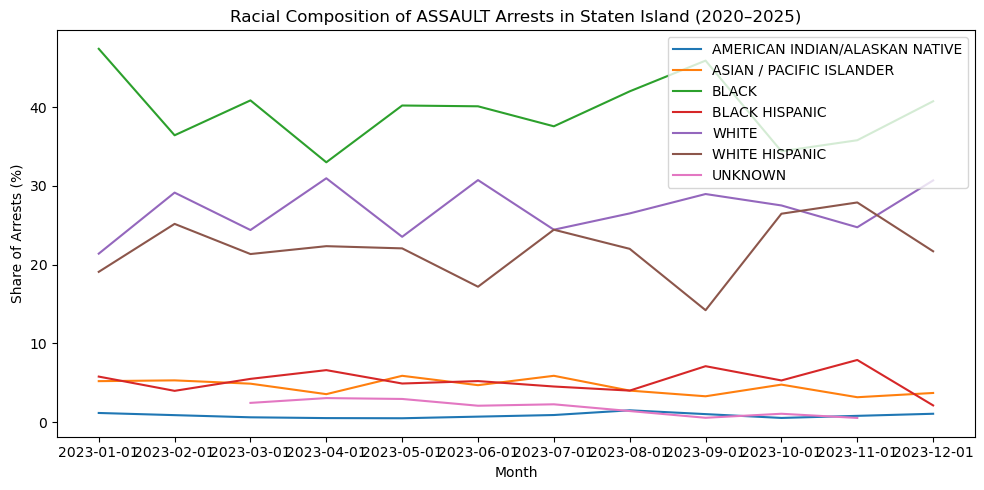

In [69]:
offense = "ASSAULT"
boro = "Staten Island"
tmp = race_off[(race_off["OFFENSE_FAM"]==offense) & (race_off["BORO"]==boro)].sort_values("YM")

plt.figure(figsize=(10,5))
sns.lineplot(data=tmp, x="YM", y="share_pct", hue="RACE")
plt.title(f"Racial Composition of {offense} Arrests in {boro} (2020–2025)")
plt.xlabel("Month"); plt.ylabel("Share of Arrests (%)")
plt.legend(); plt.tight_layout(); plt.show()

### Breakdowns and Categories

/var/folders/h4/ghspzbdd5rn19t61r1slxsf40000gn/T/ipykernel_31928/3232658340.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_offenses, x="Count", y="Offense", palette="Blues_r")


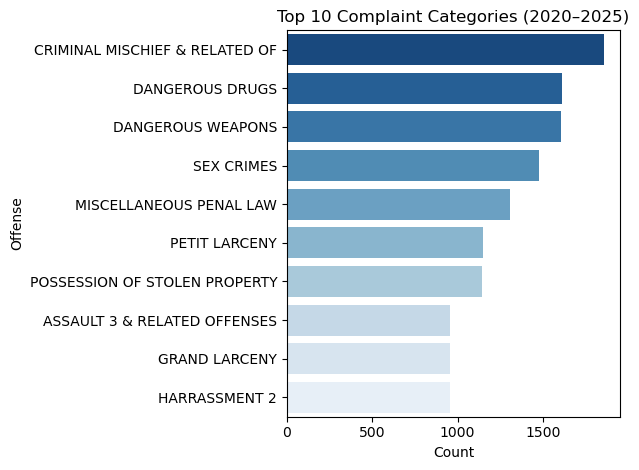

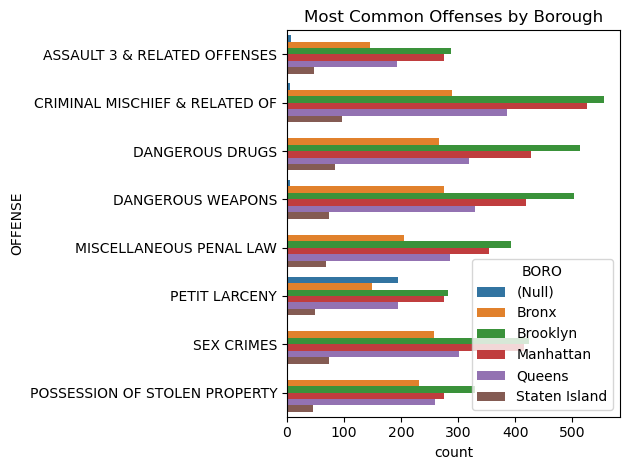

In [75]:
# Top 10 complaint categories
top_offenses = compl["OFFENSE"].value_counts().head(10).reset_index()
top_offenses.columns = ["Offense","Count"]
sns.barplot(data=top_offenses, x="Count", y="Offense", palette="Blues_r")
plt.title("Top 10 Complaint Categories (2020–2025)")
plt.tight_layout(); plt.show()

# Offense distribution by borough
off_boro = compl.groupby(["BORO","OFFENSE"]).size().reset_index(name="count")
top = off_boro.groupby("OFFENSE")["count"].sum().nlargest(8).index
off_boro = off_boro[off_boro["OFFENSE"].isin(top)]
sns.barplot(data=off_boro, x="count", y="OFFENSE", hue="BORO")
plt.title("Most Common Offenses by Borough")
plt.tight_layout(); plt.show()

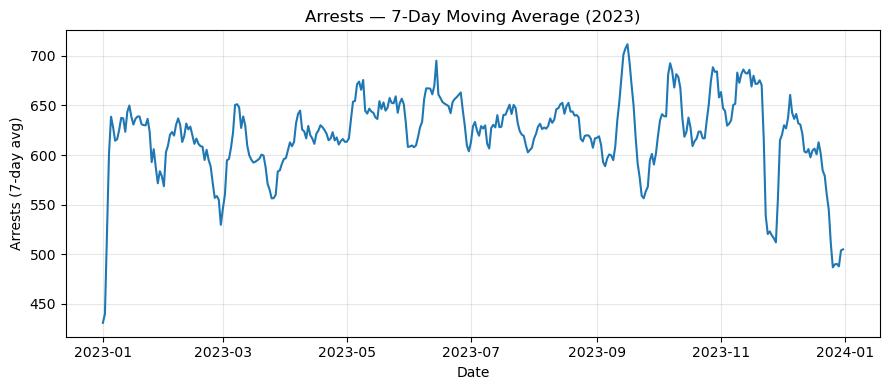

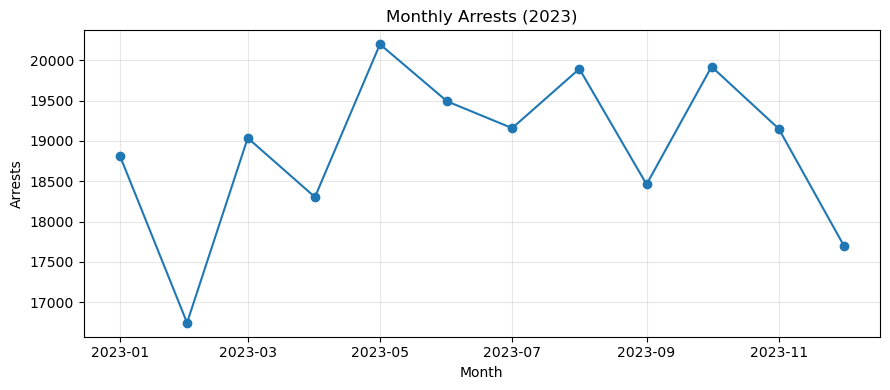

In [87]:
arrests["DATE"] = pd.to_datetime(arrests["DATE"], errors="coerce")
arrests["YM"] = arrests["DATE"].dt.to_period("M").dt.to_timestamp()

daily = (
    arrests.set_index("DATE")
           .resample("D").size()
           .rolling(7, min_periods=1).mean()
)

plt.figure(figsize=(9,4))
plt.plot(daily.index, daily.values, marker=None)
plt.title("Arrests — 7-Day Moving Average (2023)")
plt.xlabel("Date"); plt.ylabel("Arrests (7-day avg)")
plt.grid(alpha=.3); plt.tight_layout()
plt.show()

monthly = arrests.groupby("YM").size()

plt.figure(figsize=(9,4))
plt.plot(monthly.index, monthly.values, marker="o")
plt.title("Monthly Arrests (2023)")
plt.xlabel("Month"); plt.ylabel("Arrests")
plt.grid(alpha=.3); plt.tight_layout()
plt.show()


<Axes: xlabel='DOW', ylabel='count'>

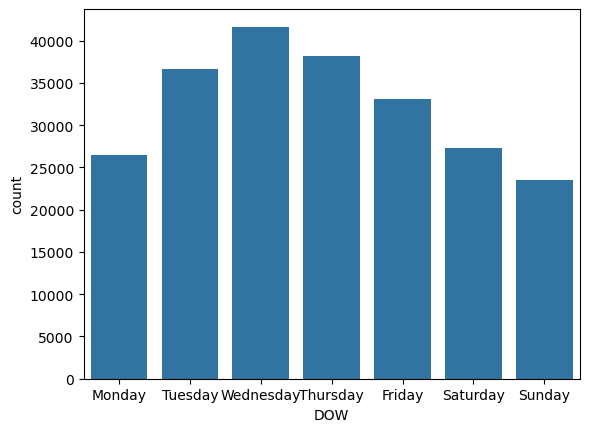

In [83]:
arrests['DOW'] = arrests['DATE'].dt.day_name()
sns.countplot(data=arrests, x='DOW', order=[
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

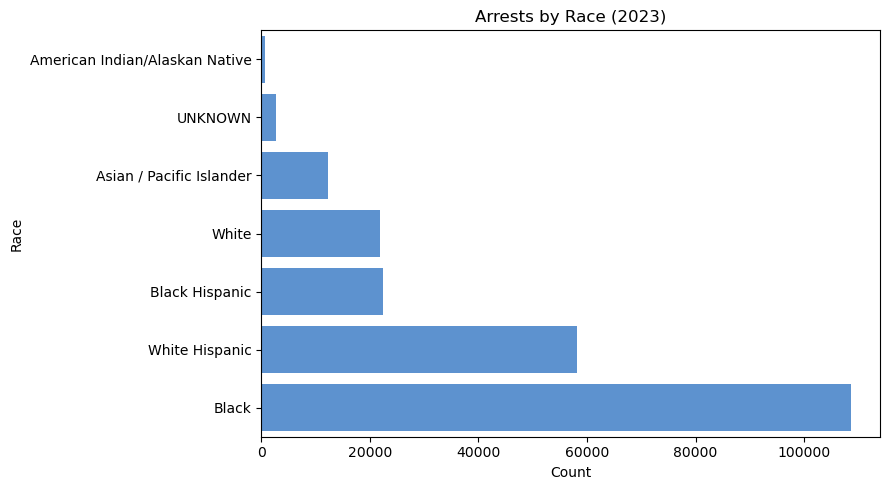

In [125]:
df = arrests.copy()

def clean_race(s):
    s = str(s).strip().upper()
    if s in ["", "NAN", "NULL", "UNKNOWN", "(NULL)"]:
        return "UNKNOWN"
    return s.title()

df["RACE_C"] = df.get("RACE", "").map(clean_race)


race_order = (df["RACE_C"].value_counts()
              .rename_axis("race").reset_index(name="n")
              .sort_values("n", ascending=True)["race"].tolist())

plt.figure(figsize=(9,5))
sns.countplot(data=df, y="RACE_C", order=race_order, color="#4A90E2")
plt.title("Arrests by Race (2023)")
plt.xlabel("Count"); plt.ylabel("Race")
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Arrests by Borough')

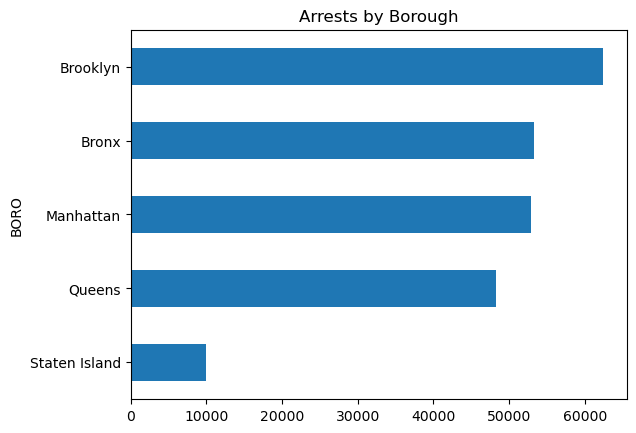

In [97]:
arrests.groupby("BORO")["PRECINCT"].count().sort_values().plot.barh()
plt.title("Arrests by Borough")

Text(0.5, 1.0, 'Top 10 Arrest Offenses (2023)')

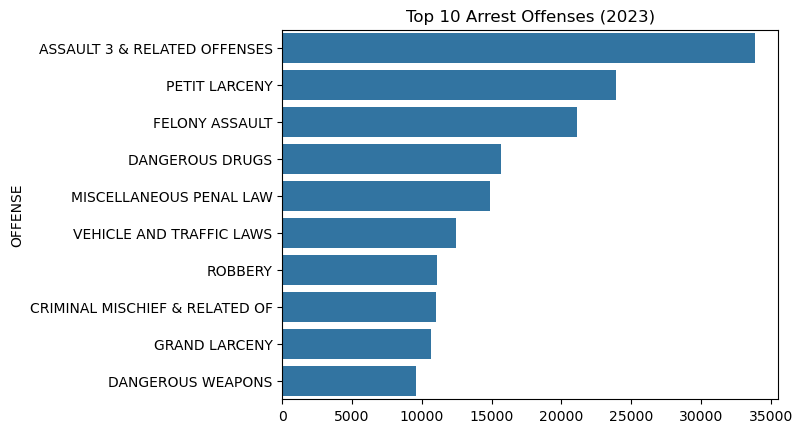

In [107]:
top_offenses = arrests["OFFENSE"].value_counts().head(10)
sns.barplot(x=top_offenses.values, y=top_offenses.index)
plt.title("Top 10 Arrest Offenses (2023)")

Text(0.5, 1.0, 'Arrest-to-Complaint Ratio by Borough (2023)')

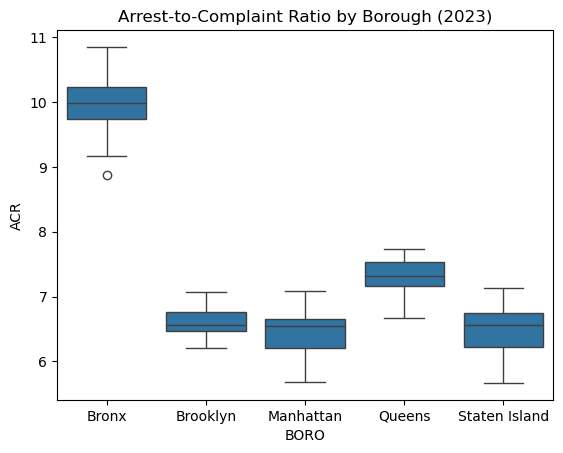

In [109]:
sns.boxplot(data=boro_m_pc, x="BORO", y="ACR")
plt.title("Arrest-to-Complaint Ratio by Borough (2023)")

<Axes: title={'center': 'Top Words in Complaint Offenses'}>

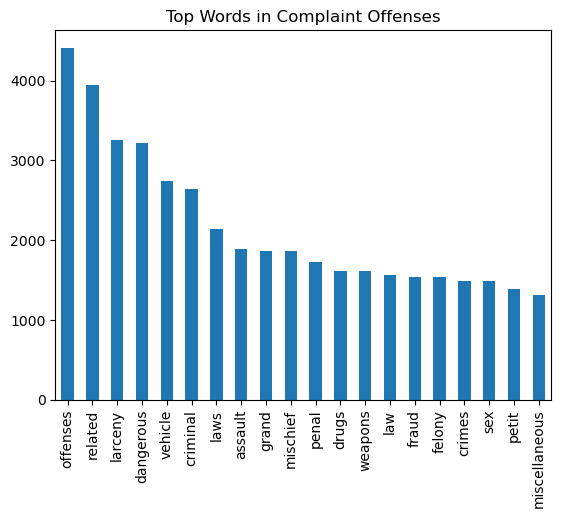

In [121]:
from sklearn.feature_extraction.text import CountVectorizer

text = compl["OFFENSE"].dropna().astype(str)
vec = CountVectorizer(stop_words="english").fit(text)
counts = pd.Series(vec.transform(text).sum(axis=0).A1, index=vec.get_feature_names_out())
counts.nlargest(20).plot.bar(title="Top Words in Complaint Offenses")